# Include libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.column import encode_categorical

# Data Preprocessing

In [2]:
data = pd.read_csv(os.path.join('..', '..', 'data', 'tidy_Stroke_Vital_Sign.csv'))

data_x = data.drop(['LOC', 'UID', 'Hospital_ID', 'SurvivalWeeks', 'admission_date',
                    'discharge_date', 'death_date', 'Mortality', 'CVDeath', 'SurvivalDays', 'CAD'], axis=1)

data_y = data[['Mortality', 'SurvivalWeeks']]

# Remove high-correlation features

In [3]:
data_x = data_x.drop(['ICU'], axis=1)

# Data split

In [4]:
# X_temp = data_x[data.LOC == '3']
# y_temp = data_y[data.LOC == '3']
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=369)

# X_test_kee = data_x[data.LOC == '2']
# y_test_kee = data_y[data.LOC == '2']

# X_test_chi = data_x[data.LOC == '6']
# y_test_chi = data_y[data.LOC == '6']

# X_test_kao = data_x[data.LOC == '8']
# y_test_kao = data_y[data.LOC == '8']


X_temp = data_x[(data.LOC == '3') | (data.LOC == '2') | (data.LOC == '6')]
y_temp = data_y[(data.LOC == '3') | (data.LOC == '2') | (data.LOC == '6')]
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=369)

X_test_kao = data_x[data.LOC == '8']
y_test_kao = data_y[data.LOC == '8']

In [5]:
categorical_columns = ['Sex', 'AF', 'DM', 'HTN', 'Hyperlipidemia', 'CHF', 'Smoking',
                       'Cancer before adm', 'Foley', 'NG', 'Dyslipidemia']
numerical_columns = np.setdiff1d(data_x.columns, categorical_columns).tolist()

categorical_ix = [data_x.columns.get_loc(col) for col in categorical_columns]
numerical_ix =  np.setdiff1d(list(range(0, len(data_x.columns))), categorical_ix).tolist()

# Numeric data standardization

In [6]:
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper

scaler = preprocessing.StandardScaler()

standardize = [([col], scaler) for col in numerical_columns]
leave = [(col, None) for col in categorical_columns]

x_mapper = DataFrameMapper(standardize + leave)

X_train = pd.DataFrame(data=x_mapper.fit_transform(X_train),
                       columns=numerical_columns+categorical_columns,
                      index=X_train.index)

X_val = pd.DataFrame(data=x_mapper.fit_transform(X_val),
                       columns=numerical_columns+categorical_columns,
                      index=X_val.index)

# X_test_kee = pd.DataFrame(data=x_mapper.fit_transform(X_test_kee),
#                       columns=numerical_columns+categorical_columns,
#                      index=X_test_kee.index)

# X_test_chi = pd.DataFrame(data=x_mapper.fit_transform(X_test_chi),
#                       columns=numerical_columns+categorical_columns,
#                      index=X_test_chi.index)

X_test_kao = pd.DataFrame(data=x_mapper.fit_transform(X_test_kao),
                      columns=numerical_columns+categorical_columns,
                     index=X_test_kao.index)

# One-hot-Encode

In [7]:
X_train = encode_categorical(X_train, columns=categorical_columns)
X_val = encode_categorical(X_val, columns=categorical_columns)
# X_test_kee = encode_categorical(X_test_kee, columns=categorical_columns)
# X_test_chi = encode_categorical(X_test_chi, columns=categorical_columns)
X_test_kao = encode_categorical(X_test_kao, columns=categorical_columns)

# Cox’s proportional hazard’s model

In [8]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
y_train_cox =  y_train.copy()
y_train_cox.loc[:, 'Mortality'] = y_train_cox['Mortality'].astype(bool)
y_train_cox = np.array(list(y_train_cox.to_records(index=False)))

# kee
# y_test_kee_cox =  y_test_kee.copy()
# y_test_kee_cox.loc[:, 'Mortality'] = y_test_kee_cox['Mortality'].astype(bool)
# y_test_kee_cox = np.array(list(y_test_kee_cox.to_records(index=False)))
# Chi
# y_test_chi_cox =  y_test_chi.copy()
# y_test_chi_cox.loc[:, 'Mortality'] = y_test_chi_cox['Mortality'].astype(bool)
# y_test_chi_cox = np.array(list(y_test_chi_cox.to_records(index=False)))
# Kao
y_test_kao_cox =  y_test_kao.copy()
y_test_kao_cox.loc[:, 'Mortality'] = y_test_kao_cox['Mortality'].astype(bool)
y_test_kao_cox = np.array(list(y_test_kao_cox.to_records(index=False)))


estimator.fit(X_train, y_train_cox)
# print('Kee C-index = %.3f' %(estimator.score(X_test_kee, y_test_kee_cox)))
# print('Chi C-index = %.3f' %(estimator.score(X_test_chi, y_test_chi_cox)))
print('Kao C-index = %.3f' %(estimator.score(X_test_kao, y_test_kao_cox)))


Kao C-index = 0.830


# RF

In [9]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=369)

rsf.fit(X_train, y_train_cox)

# print('Kee C-index = %.3f' %(rsf.score(X_test_kee, y_test_kee_cox)))
# print('Chi C-index = %.3f' %(rsf.score(X_test_chi, y_test_chi_cox)))
print('Kao C-index = %.3f' %(rsf.score(X_test_kao, y_test_kao_cox)))

Kao C-index = 0.834


# Deepsur (CoxPH)

In [10]:
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [11]:
import torch
import torchtuples as tt

np.random.seed(369)
_ = torch.manual_seed(369)

## input processing for model

In [12]:
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
# X_test_kee = X_test_kee.values.astype('float32')
# X_test_chi = X_test_chi.values.astype('float32')
X_test_kao = X_test_kao.values.astype('float32')

get_target = lambda df: (df['SurvivalWeeks'].values, df['Mortality'].values)
y_train = get_target(y_train)
y_val = get_target(y_val)

val = X_val, y_val

# durations_test_kee, events_test_kee = get_target(y_test_kee)
# durations_test_chi, events_test_chi = get_target(y_test_chi)
durations_test_kao, events_test_kao = get_target(y_test_kao)


In [13]:
in_features = X_train.shape[1]
num_nodes = [64, 64, 64]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

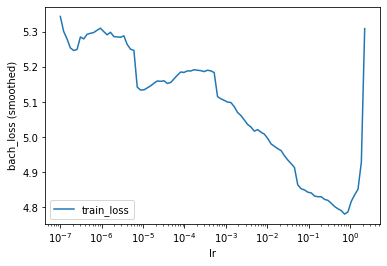

In [14]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [15]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [16]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
verbose = True

In [17]:
log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.6648,	val_loss: 4.6062
1:	[0s / 0s],		train_loss: 4.3203,	val_loss: 4.5243
2:	[0s / 0s],		train_loss: 4.3229,	val_loss: 4.3849
3:	[0s / 0s],		train_loss: 4.2454,	val_loss: 4.3793
4:	[0s / 0s],		train_loss: 4.2024,	val_loss: 4.3606
5:	[0s / 0s],		train_loss: 4.2286,	val_loss: 4.3966
6:	[0s / 0s],		train_loss: 4.1715,	val_loss: 4.5765
7:	[0s / 0s],		train_loss: 4.1851,	val_loss: 4.3523
8:	[0s / 0s],		train_loss: 4.1610,	val_loss: 4.3815
9:	[0s / 1s],		train_loss: 4.1388,	val_loss: 4.4410
10:	[0s / 1s],		train_loss: 4.1832,	val_loss: 4.3707
11:	[0s / 1s],		train_loss: 4.1557,	val_loss: 4.4059
12:	[0s / 1s],		train_loss: 4.1752,	val_loss: 4.4253
13:	[0s / 1s],		train_loss: 4.1243,	val_loss: 4.4017
14:	[0s / 1s],		train_loss: 4.1730,	val_loss: 4.6209
15:	[0s / 1s],		train_loss: 4.1276,	val_loss: 4.4109
16:	[0s / 1s],		train_loss: 4.0971,	val_loss: 4.4321
17:	[0s / 1s],		train_loss: 4.1090,	val_loss: 4.5962
18:	[0s / 2s],		train_loss: 4.1723,	val_loss: 4.4845
19:

## Prediction

In [18]:
_ = model.compute_baseline_hazards()
# surv_kee = model.predict_surv_df(X_test_kee)
# surv_chi = model.predict_surv_df(X_test_chi)
surv_kao = model.predict_surv_df(X_test_kao)

## Evaluation

In [19]:
# ev_kee = EvalSurv(surv_kee, durations_test_kee, events_test_kee, censor_surv='km')
# print('Kee C-index = %.3f' %(ev_kee.concordance_td()))

# ev_chi = EvalSurv(surv_chi, durations_test_chi, events_test_chi, censor_surv='km')
# print('Chi C-index = %.3f' %(ev_chi.concordance_td()))

ev_kao = EvalSurv(surv_kao, durations_test_kao, events_test_kao, censor_surv='km')
print('Kao C-index = %.3f' %(ev_kao.concordance_td()))

Kao C-index = 0.833
